# Good Seed - Computer Vision

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to underage customers. The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

## Goal

Develop a model that identifies the age of a person based on an image. Return a model that predicts age with the lowest mean absolute average. 

## Process

### 1. Prepare Data
- Initialize packages
- Load data

### 2. Exploratory Data Analysis
- Assess distribution       

### 3. Run Model
- Load train
- Load test
- Create model
- Train model

### 4. Model Analysis
- How effective is the model?
- How can it be used to save resources?
- For fun: how old do I, my fiance, and my dogs look? 


## Data

7.5k photos can be found in the  `datasets/faces/final_files` folder. Accompanying ages are saved in the `datasets/faces/labels.csv` file. 

## 1. Prepare Data

### Initialize Packages

In [27]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image

# Statistical analysis
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import f1_score



# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers.legacy import Adam

### Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`


The label file can be loaded as a usual CSV file.

### Labels Data

Load data. Check for missing and odd values.

In [2]:
labels = pd.read_csv('../datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# ensure each file name is unique (equal to 7591)
labels['file_name'].nunique()

7591

In [5]:
# check for appropriate age range
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


The age range includes those from ages 1-100. All data within labels is appropriate. Merge these values to final_files image using ImageDataGenerator.

### Labels and Image Merge

In [6]:
datagen = ImageDataGenerator()

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='../datasets/faces/final_files',  # the folder with the dataset
    x_col='file_name',  # the column containing image filenames
    y_col='real_age',  # the column containing target labels
    target_size=(150, 150),  # the target image size
    batch_size=16,  # the batch size
    class_mode='raw',# set class mode to 'raw' for regression analysis
    seed=12345  # set a random number generator seed
)

Found 7591 validated image filenames.


In [7]:
# Get a batch of data from the datagen_flow object
images, ages = next(datagen_flow)

# Rescale pixel values to the range [0, 1]
images = images / 255.0

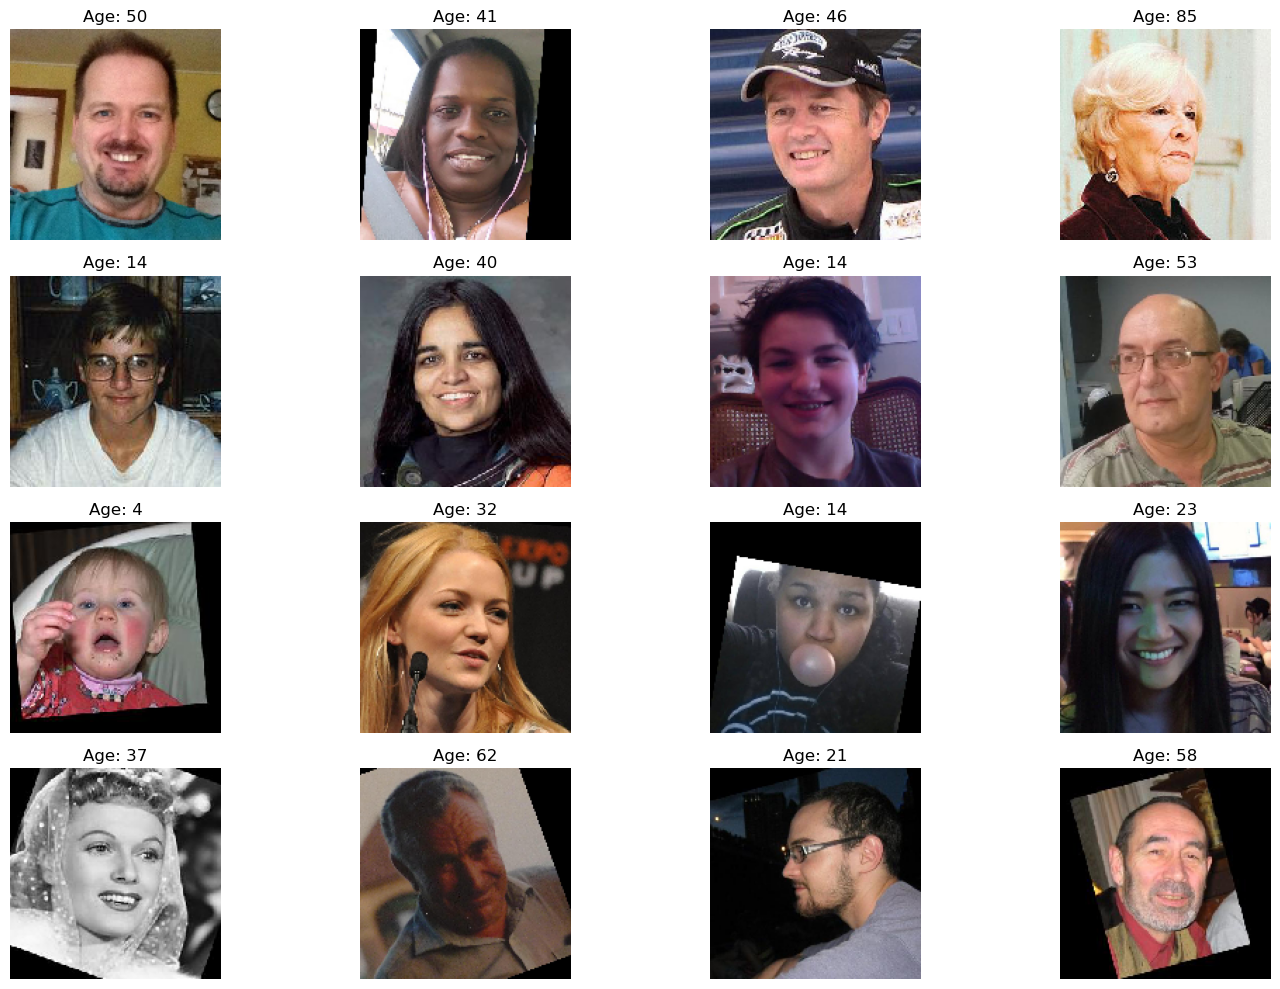

In [8]:
# Display image batch along with their corresponding ages
plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {ages[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

From the small sample, it appears that a variety of faces have been provided. These are shown at different angles and even vary between colour and grayscale. This will help as cameras may not always capture the best angle of a person when at the checkout register.

## 2. Exploratory Data Analysis

Ages of photographed people will be assessed using a histogram and boxplot. If a certain age is not represented well enough, weaknesses may be present.

In [9]:
# Calculate the mean of ages
mean_age = labels['real_age'].mean()

# Create histogram of ages using Plotly
fig = px.histogram(labels, x='real_age', nbins=100, title='Distribution of Ages', color_discrete_sequence=['hotpink'])
fig.update_traces(opacity=0.5)  # Set opacity to 0.5 for transparency
fig.update_layout(xaxis_title='Age', yaxis_title='Frequency')

# Add a vertical line for the mean age
fig.add_vline(x=mean_age, line_dash='dash', line_color='white', annotation_text=f'Mean: {mean_age:.2f}')

# Make dark theme
fig.update_layout(template='plotly_dark')

fig.show()

In [10]:
# Create horizontal box plot of ages
fig = px.box(labels, x='real_age', orientation='h', title='Box Plot of Ages')

# Title x-axis
fig.update_layout(xaxis_title='Age')

# Make dark theme
fig.update_layout(template='plotly_dark')

# Save as image
fig.write_image('../pics/box_plot.png')

# Show figure
fig.show()

### Findings

Age is represented in a right skewed distribution. The median age is 29 while the mean is at 31. 75% of people photographed are younger than 73. This means that more data will be provided that identify young adults rather than older people. The model may struggle more when provided with pictures of those who fall into that latter category.

## 3. Run Model

To create a model the following must be completed:

1. Load training data
2. Load validation data
3. Initiate the model
4. Train the model

In [11]:
# Load training data
path = '../datasets/faces/'

df_face = pd.read_csv(path + 'labels.csv')

train_datagen = ImageDataGenerator(
    validation_split=0.25,
    horizontal_flip=True,
    rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df_face,
    directory='../datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345
    )

Found 5694 validated image filenames.


In [12]:
# Load validation data
df_face = pd.read_csv(path + 'labels.csv')

test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
test_datagen_flow = test_datagen.flow_from_dataframe(
dataframe=df_face,
directory='../datasets/faces/final_files/',
x_col='file_name',
y_col='real_age',
target_size=(224, 224),
batch_size=16,
class_mode='raw',
subset='validation',
seed=12345
)

Found 1897 validated image filenames.


In [13]:
# Create model
input_shape = (224, 224, 3)

backbone = ResNet50(weights='imagenet',
                    input_shape=input_shape,
                    include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [14]:
# Train the model

# Set hyperparameters
train_data = train_datagen_flow
test_data = test_datagen_flow
batch_size = 16
epochs = 5
steps_per_epoch = len(train_data)
validation_steps = len(test_data)

# Train the model
history = model.fit(train_data,
                validation_data=test_data,
                batch_size=batch_size,
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_steps=validation_steps,
                verbose=2)


Epoch 1/5
356/356 - 918s - loss: 240.8024 - mae: 11.2000 - val_loss: 328.3821 - val_mae: 13.3892 - 918s/epoch - 3s/step
Epoch 2/5
356/356 - 1125s - loss: 91.3019 - mae: 7.2528 - val_loss: 174.3143 - val_mae: 9.9364 - 1125s/epoch - 3s/step
Epoch 3/5
356/356 - 1070s - loss: 66.4211 - mae: 6.2252 - val_loss: 72.2083 - val_mae: 6.3949 - 1070s/epoch - 3s/step
Epoch 4/5
356/356 - 1192s - loss: 47.2947 - mae: 5.2382 - val_loss: 138.4105 - val_mae: 9.3910 - 1192s/epoch - 3s/step
Epoch 5/5
356/356 - 1155s - loss: 41.4093 - mae: 4.8600 - val_loss: 91.6563 - val_mae: 7.3969 - 1155s/epoch - 3s/step


In [15]:
# Save the model
model_save = model.save('models/age_prediction_model.h5')

/Users/lizzd/anaconda3/envs/qtconsole/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [16]:
# Import model
model = tf.keras.models.load_model('../models/age_prediction_model.h5')

In [17]:
# Initialize lists
predictions = []
actual_labels = []
image_filenames = []

# Iterate over batches of data
for i, (images, labels) in enumerate(test_datagen_flow):
    # Make predictions for the current batch
    batch_predictions = model.predict(images)
    # Flatten predictions and add to the predictions list
    predictions.extend(batch_predictions.flatten())
    # Extend actual labels list with the current batch labels
    actual_labels.extend(labels)
    # Extend image filenames list with the current batch filenames
    batch_filenames = test_datagen_flow.filenames[i * test_datagen_flow.batch_size : (i + 1) * test_datagen_flow.batch_size]
    image_filenames.extend(batch_filenames)
    # Break the loop if all batches have been processed
    if i == len(test_datagen_flow) - 1:
        break

# Convert actual labels to a numpy array
actual_labels = np.array(actual_labels)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(actual_labels - predictions))

# Print the mean absolute error
print(f'Mean Absolute Error: {mae:.2f}')

1/1 [==============================] - 0s 379ms/step
Mean Absolute Error: 6.10


The model returns a mean absolute error of 6.1, which means that the average difference between the predicted age and the actual age is 6.1 years. This is a reasonable result given the complexity of the task and the limited training data.

## 4. Model Analysis
    - How effective is the model?
    - How can it be used to save resources?
    - For fun: how old do I, my fiance, and my dogs look? 

### Model Efficacy

Predictions of ages will be saved to make direct comparisons to actual ages. Distributions will be compared before the data is given a classification spin to identify how good the model is at predicting if a customer is over the age of 21. 

#### Distribution Between Actual Age and Predicted Age

In [18]:
# create dataframe with actual and predicted values
df = pd.DataFrame({'actual': actual_labels, 'predicted': predictions, 'file_name': image_filenames})

# find difference between actual and predicted values
df['difference'] = df['actual'] - df['predicted']

In [19]:
# Create histogram of actual and predicted values
fig = px.histogram(df, x=['actual','predicted'], nbins=100, title='Actual vs Predicted Values', color_discrete_sequence=['hotpink', 'aqua'], barmode='overlay')

# Make it dark theme
fig.update_layout(template='plotly_dark')

# Save figure
fig.write_image('../pics/actual_vs_predicted.png')

# Show figure
fig.show()

In [20]:
# Compare boxplots of actual and predicted values
fig = px.box(df, x=['actual', 'predicted'], title='Box Plot of Actual and Predicted Values')

# Save as dark theme
fig.update_layout(template='plotly_dark')

# Save as image
fig.write_image('../pics/box_plot_actual_vs_predicted.png')

fig.show()

In [21]:
# Calculate the range of differences
min_diff = df['difference'].min()
max_diff = df['difference'].max()

# Create bin edges that ensure each bin represents one exact value
bin_edges = np.arange(min_diff, max_diff + 1, 1)

# Round the difference values to the nearest integer
df['difference'] = np.round(df['difference'])

# Create the histogram
fig = px.histogram(df, 
                   x='difference', 
                   title='Difference between Actual and Predicted Values', 
                   color_discrete_sequence=['aqua','hotpink'],
                   histnorm='percent')

# Save legend title
fig.update_layout(legend_title_text='Over 21')

# Apply dark theme
fig.update_layout(template='plotly_dark')

# Save the figure
fig.write_image('../pics/difference.png')

# Show the figure
fig.show()

In [22]:
# Create predicted rounded down column
df['predicted_rounded_down'] = np.floor(df['predicted'])

# Create the histogram
fig = px.histogram(
    df,
    x='predicted_rounded_down',
    color=(df['actual'] > 20).astype(str),
    title='Distribution of Predicted Ages',
    nbins=df['predicted_rounded_down'].nunique(),
    color_discrete_map={'False': 'aqua', 'True': 'hotpink'}
)

# Put line in at 21
fig.add_vline(x=21, line_dash='dash', line_color='red')

# Set legend title to Over 21
fig.update_layout(legend_title='Actually Over 21')

# Apply dark theme
fig.update_layout(template='plotly_dark')

# Save the figure
fig.write_image('../pics/predicted_ages.png')

# Show the figure
fig.show()

In [26]:
# Assuming df is your DataFrame and has columns 'predicted' and 'actual'
df['predicted_rounded_down'] = np.floor(df['predicted'])

# Filter data into two groups
df_over_21 = df[df['actual'] > 20]
df_under_21 = df[df['actual'] <= 20]

# Create KDE for the predicted ages for each group
kde_over_21 = gaussian_kde(df_over_21['predicted_rounded_down'])
kde_under_21 = gaussian_kde(df_under_21['predicted_rounded_down'])

# Generate x values for plotting
x_vals = np.linspace(df['predicted_rounded_down'].min(), df['predicted_rounded_down'].max(), 1000)

# Evaluate the KDEs
y_vals_over_21 = kde_over_21(x_vals)
y_vals_under_21 = kde_under_21(x_vals)

# Create the figure
fig = go.Figure()

# Add KDE line for those over 21
fig.add_trace(go.Scatter(x=x_vals, y=y_vals_over_21, mode='lines', line=dict(color='hotpink'), name='Over 21'))

# Add KDE line for those under 21
fig.add_trace(go.Scatter(x=x_vals, y=y_vals_under_21, mode='lines', line=dict(color='aqua'), name='Under 21'))

# Add vertical line at 21
fig.add_vline(x=21, line_dash='dash', line_color='red', annotation_text='Age 21', annotation_position='top right')

# Set title and legend
fig.update_layout(
    title='Continuous Probability Function of Predicted Ages',
    xaxis_title='Predicted Age',
    yaxis_title='Density',
    legend_title='Age Group',
    template='plotly_dark'
)

# Save the figure
fig.write_image('../pics/predicted_ages.png')

# Show the figure
fig.show()


In [28]:
# Round down the predicted ages
df['predicted_rounded_down'] = np.floor(df['predicted'])

# Filter data into two groups
df_over_21 = df[df['actual'] > 20]
df_under_21 = df[df['actual'] <= 20]

# Function to calculate the CDF
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Calculate CDF for each group
x_vals_over_21, y_vals_over_21 = calculate_cdf(df_over_21['predicted_rounded_down'])
x_vals_under_21, y_vals_under_21 = calculate_cdf(df_under_21['predicted_rounded_down'])

# Create the figure
fig = go.Figure()

# Add CDF line for those over 21
fig.add_trace(go.Scatter(x=x_vals_over_21, y=y_vals_over_21, mode='lines', line=dict(color='hotpink'), name='Over 21'))

# Add CDF line for those under 21
fig.add_trace(go.Scatter(x=x_vals_under_21, y=y_vals_under_21, mode='lines', line=dict(color='aqua'), name='Under 21'))

# Add vertical line at 21
fig.add_vline(x=21, line_dash='dash', line_color='red', annotation_text='Age 21', annotation_position='top right')

# Set title and legend
fig.update_layout(
    title='Cumulative Density Function of Predicted Ages',
    xaxis_title='Predicted Age',
    yaxis_title='Cumulative Density',
    legend_title='Actual Age Group',
    template='plotly_dark'
)

# Save the figure
fig.write_image('../pics/predicted_ages1.png')

# Show the figure
fig.show()

In [37]:
# Find values with predicted age under 21, but actual age over 21
df_misclassified = df[(df['predicted_rounded_down'] < 21) & (df['actual'] > 20)]

# Show df_missclassified
df_misclassified['predicted_rounded_down'].value_counts()

predicted_rounded_down
20.0    25
19.0    15
18.0     9
16.0     9
17.0     8
14.0     5
15.0     3
12.0     1
Name: count, dtype: int64

In [42]:
# Find values with predicted age over 21, but actual age under 21
df_misclassified = df[(df['predicted_rounded_down'] > 21) & (df['actual'] <= 20)]

# Show df_missclassified
df_misclassified['predicted_rounded_down'].value_counts()

predicted_rounded_down
22.0    32
26.0    27
23.0    27
25.0    23
24.0    18
27.0    16
28.0    11
30.0     8
29.0     7
32.0     7
31.0     6
34.0     5
33.0     4
35.0     3
36.0     2
39.0     1
41.0     1
38.0     1
42.0     1
Name: count, dtype: int64

In [45]:
# Percentage of people that are 12 or under or 40 and over
percentage = df[(df['predicted'] < 12) | (df['predicted'] > 42)].shape[0] / df.shape[0] * 100

# Show percentage of test that fits this range
percentage

23.827095413811282

### Analysis

Those that are actually under 21 are being categorized as underage 63% of the time. This doesn't sound too great, but you have to remember the distribution of actual ages in this data set where more than half are under 30. Everybody that is predicted to be 12 and under is correctly identified as those that are under 21.

Those that are actually over 21 are being categorized as over 21 in 95% of cases. Those that are predicted to be over 40 actually are in this case too.

Using this information, 29% of users can be safely identified, when they fit within the predicted age of under 12 and over 40. However, this would need to be replicated.

Also note that most people purchasing items at a grocery store are hardly 12. Instead the median age of customers at a grocery store is estimated to be 44, according to [this source](https://adplanetads.com/spotlight/grocery-shopper-demographics-retail-dooh/#:~:text=Age%3A%20The%20average%20age%20of,their%20own%20ways%20of%20shopping.)

In [44]:
# Show distribution of actual ages again
fig = px.histogram(df, x='actual', nbins=100, title='Distribution of Actual Ages', color_discrete_sequence=['hotpink'])

# Add vertical lines for Q1, Q2, and Q3
fig.add_vline(x=df['actual'].quantile(0.25), line_dash='dash', line_color='white', annotation_text='Q1')
fig.add_vline(x=df['actual'].quantile(0.5), line_dash='dash', line_color='white', annotation_text='Q2')
fig.add_vline(x=df['actual'].quantile(0.75), line_dash='dash', line_color='white', annotation_text='Q3')

# Make dark theme
fig.update_layout(template='plotly_dark')

# Show figure
fig.show()

In [46]:
# Print summary statistics of actual and predicted values
print(df.describe())

            actual    predicted   difference  predicted_rounded_down
count  1897.000000  1897.000000  1897.000000             1897.000000
mean     29.616236    29.723772    -0.099631               29.230890
std      16.764323    13.538309     8.057944               13.522294
min       1.000000     0.000000   -38.000000                0.000000
25%      18.000000    22.052916    -5.000000               22.000000
50%      27.000000    28.673775    -1.000000               28.000000
75%      40.000000    36.530182     5.000000               36.000000
max      90.000000    86.277725    40.000000               86.000000


The model predicts ages 0.2 years older on average (median). Ideally this value would be zero, but is more hurtful to the project as it would pull more people who are younger above the legal alcohol purchasing age threshold.

#### Precision, Recall, and F1 Scores

By categorizing data as either above or under the legal drinking age, certain scores can be compared to a constant model (sanity check). Precision measures the number of false positives 

In [47]:
# Create new column 'over 20' in the dataframe
df['over_20'] = df['actual'].apply(lambda x: 1 if abs(x) > 20 else 0)

# Create new column 'predicted over 20' in the dataframe
df['predicted_over_20'] = df['predicted'].apply(lambda x: 1 if x > 20 else 0)

# Create new column where both 'over 20' and 'predicted over 20' are the same
df['correct'] = df['over_20'] == df['predicted_over_20']

In [48]:
# Calculate true positive, false positive, and precision
true_positives = ((df['over_20'] == 1) & (df['predicted_over_20'] == 1)).sum()
false_positives = ((df['over_20'] == 0) & (df['predicted_over_20'] == 1)).sum()


precision = true_positives / (true_positives + false_positives)

print("Precision:", precision)

Precision: 0.8310502283105022


In [49]:
# Calculate accuracy as correctly identifed as over 20 or not
accuracy = df['correct'].mean()

# Display Accuracy
print(f'Accuracy of model: {round(accuracy,2) * 100}')

Accuracy of model: 84.0


#### Sanity Check

Give constant age according to distribution.

In [50]:
# Create new column equal to the median of the 'Actual' column
df['median'] = df['actual'].median()

# Create new column 'over_20_median' in the dataframe
df['over_20_median'] = df['median'].apply(lambda x: 1 if abs(x) > 20 else 0)

# Create new column where both 'over 20' and 'over_20_median' are the same
df['median_correct'] = df['over_20'] == df['over_20_median']

# Calculate accuracy as correctly identifed as over 20 or not
median_accuracy = df['median_correct'].mean()

# Display Accuracy
print(f'Accuracy of median model: {round(median_accuracy,2) * 100}')

Accuracy of median model: 70.0


F1 scores will be a better metric to compare to. F1 scores take into account precision and recall. Precision asks of all the actual positive items, how many did the classifier correctly identify? For instance, of those that were identified as over 20, how many actually were over 20?

In [51]:
# Calculate F1 score for the model
f1 = f1_score(df['over_20'], df['predicted_over_20'])

#show f1 score
print(f'F1 score of model: {f1.round(2)}')

# show f1 of constant model
f1_constant = f1_score(df['over_20'], df['over_20_median'])

# show f1 of constant model
print(f'F1 score of constant model: {f1_constant.round(2)}')

F1 score of model: 0.89
F1 score of constant model: 0.82


In [52]:
# save confusion matrix
confusion_matrix = pd.crosstab(df['over_20'], df['predicted_over_20'])

# show confusion matrix
print(f'Confusion matrix of model: \n{confusion_matrix}')

Confusion matrix of model: 
predicted_over_20    0     1
over_20                     
0                  314   259
1                   50  1274


In [54]:
# Calculate precision
precision = confusion_matrix.loc[1, 1] / (confusion_matrix.loc[1, 1] + confusion_matrix.loc[0, 1])
precision

0.8310502283105022

In [55]:
# calculate recall
recall = confusion_matrix.loc[1, 1] / (confusion_matrix.loc[1, 1] + confusion_matrix.loc[1, 0])
recall

0.9622356495468278

Both high but recall is much better. This indicates that the model did not result in too many false negatives (50 out of 1897). In other words, out of those that were actually over 21, only 50 were predicted to be under age. 259 on the other hand were predicted to be over 21 when they actually weren't. 

#### Accuracy as Prediction Ages Increases

As the prediction age increases, the actual ages of customers that are over 20 also increases. This idea can help identify at what point the model is completely accurate. A graph will be made to illustrate this idea.

In [56]:
df['over_21'] = df['actual'].apply(lambda x: 1 if x > 21 else 0)

# create copy of df
df1 = df.copy()

accuracy_under_21 = []

for age in range(0, 21):
    # make a copy of the DataFrame at the beginning of each iteration
    df_copy = df1.copy()
    
    # slice the dataframe to only include rows where predicted age is under 'age'
    df_slice = df_copy[df_copy['predicted'] <= age]
    
    # Find average of predicted under 21
    average = 1 - df_slice['over_21'].mean()

    # save the average to a list
    accuracy_under_21.append({age: average})

# create copy of df
df1 = df.copy()

accuracy_over_21 = []

for age in range(21, 100):  # corrected range
    # make a copy of the DataFrame at the beginning of each iteration
    df_copy = df1.copy()
    
    # slice the dataframe to only include rows where predicted age is over 'age'
    df_slice = df_copy[df_copy['predicted'] > age]
    
    # Find average of predicted over 21
    average = df_slice['over_21'].mean()

    # save the average to a list
    accuracy_over_21.append({age: average})


In [57]:
# Create plot
fig = go.Figure()

# Add a line plot for the accuracy over 21
fig.add_trace(go.Scatter(x=[list(x.keys())[0] for x in accuracy_over_21],
                         y=[list(x.values())[0] for x in accuracy_over_21],
                         mode='lines',
                         name='Over 21'))

# Add a line plot for the accuracy under 21
fig.add_trace(go.Scatter(x=[list(x.keys())[0] for x in accuracy_under_21],
                         y=[list(x.values())[0] for x in accuracy_under_21],
                         mode='lines',
                         name='Under 21'))

# Add horizontal line at age 21
fig.add_shape(type="line", x0=21, y0=0, x1=21, y1=1.2, line=dict(color="black", width=2, dash="dash"))

# Add histogram of predicted ages as a percentage with Gaussian kernel density estimation
fig.add_trace(go.Histogram(x=df['predicted'],
                            nbinsx=100,
                            name='Ages',
                            marker_color='hotpink',
                            histnorm='probability',  # Normalize histogram to probability
                            cumulative_enabled=True,  # Enable cumulative accumulation
                            opacity=0.5,
                            marker=dict(color='rgba(0,0,0,0)')  # Make the histogram transparent
                            ))

# Update layout
fig.update_layout(title='Accuracy as Prediction Ages Increases',
                  xaxis_title='Distribution of Ages',
                  yaxis_title='Accuracy (%)')

# Change to dark theme
fig.update_layout(template='plotly_dark')

# Save plot to file
fig.write_image('accuracy_prediction_ages.png')

# Show plot
fig.show()

##### Analysis

If the model predicts that someone is 21, 91.6% of the time that person is actually over 21 and able to purchase alcohol. If the model predicts someone to be 30 or older, that customer is over 20 on 98% of occasions. This hits 100% at the age of 40, so the model is flawless at determining if someone can legally purchase alcohol over this age. Online research suggests that 50% of all grocery customers are above this age (statistica). 

This signifies how beneficial this model may be by reducing the need to identify almost a third of all alcohol purchases (assuming that alcohol purchases remain uniform across all ages). However, more research about the distribution of age of alcohol consumers would need to be made.

The redline represents how accurate the model is at predicting if the customer is under 21 at different ages. For instance, if the model predicted the customer to be 9 years old, the customer was 100% guaranteed to be younger than 21. However, 9 year old customers are rare. When the customer is predicted to be 16, 97% of the time they were under 21. 

84% accurate at age 21 (23% of the distribution). 95% accurrate at age 30 (56% of the distribution). 

#### Self Test

And now for the fun part, how good is the model at predicting my age, my fiance's age and my dogs' ages?

In [69]:
# Test photo of myself, my fiance and my dogs
personal = ['../datasets/faces/personal/me2.png', '../datasets/faces/personal/fiance.jpg', '../datasets/faces/personal/farley.jpg','../datasets/faces/personal/fitzroy.jpg']

# Save actual ages
personal_ages = ['?', '?', 8, 1]

# Load the images
images = [Image.open(image) for image in personal]

1/1 [==============================] - 0s 58ms/step


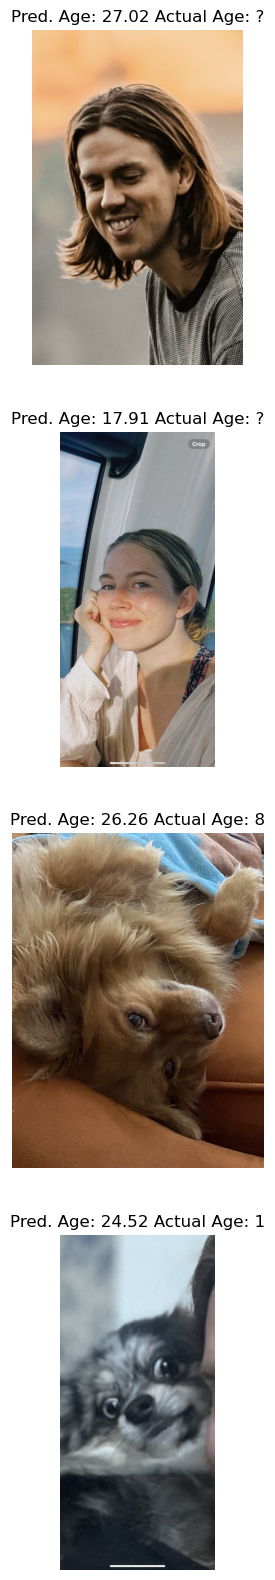

In [70]:
# Run the model with personal pics
plt.figure(figsize=(5, len(images) * 5))  # Adjust figure size based on number of images

for i, image in enumerate(images):
    # Preprocess image
    image = image.resize((224, 224))  # Resize image
    image = image.convert('RGB')  # Convert to RGB
    image = np.array(image) / 255.0  # Normalize pixel values
    image = image.reshape(1, 224, 224, 3)  # Reshape for model input
    
    # Predict age
    age = model.predict(image)
    
    # Display image, predicted age, and actual age
    plt.subplot(len(images), 1, i + 1)  # Change the subplot layout to vertical
    plt.imshow(images[i])
    plt.title(f'Pred. Age: {age[0][0]:.2f} Actual Age: {personal_ages[i]}')
    plt.axis('off')

plt.show()

Fortunately the model thinks I am an appropriate age and not too old. But, How can we really trust it now? Interestingly, my fiance is now significantly younger than me and even younger than our dogs!

## Conclusions

### Mean Absolute Error

The model returns a mean absolute error of 6.1 on the validation set. This indicates that on average, predictions are 6.1 years off a person's actual age. This may seem like a large range, but becomes more useful when considering all provided ages in the test set range from 1 to 90.

### Prediction Age Increase and Alcohol Purchase Age

If the legal alcohol purchasing age is 21, the model would eliminate the need to identify customers over the age of 40 and under 12 (around one third of all customers). Those identified as 35 would likely be allowed to purchase alcohol as 95% of these customers are older than 21, giving greater confidence to the model.

### Alternative Paths

This model could also help Good Seed financially. Firstly, they could identify what products are being bought by each age group. For instance, Good Seed could identify certain products that are bought more by elderly people. As elderly people may require more help accessing products, the store could place these items closer to the front, making it easier for them to purchase items and incentivising shopping at Good Seed over other stores. 

Secondly, this information could also be useful for suppliers who might want to identify their target audiences. Good Seed could sell this information and charge for specific shelf spacing based on customer preferences.